<a href="https://colab.research.google.com/github/Roy-Byun/Casual_Model_for_Bias_Detection_and_Mitigation_for_CNN/blob/main/Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning frameworks
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Causal inference libraries
# !pip install dowhy
# import dowhy
# from dowhy import CausalModel

# For handling images
from PIL import Image
import cv2
import os

# For displaying progress
from tqdm import tqdm


In [ ]:
# Check if GPU is available
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Move to directory where the dataset is stored
%cd /content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/

/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset


In [ ]:
# List all files in the current directory
# !ls

In [ ]:
# Unzip the file to a directory in Colab. Run only once
# !unzip archive.zip -d "/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/"


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace

/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace


In [ ]:
# Load labels
train_df = pd.read_csv('train_labels.csv')
# val_df = pd.read_csv('val_labels.csv')

# Preview the DataFrame
train_df.head()

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


In [ ]:
# Install & Import Deepface
!pip install deepface
!pip install --upgrade opencv-python

In [ ]:
from deepface import DeepFace
import logging

# Define the base paths for train and val images
train_image_base_path = '/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/'
val_image_base_path = '/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/'

# Load labels for training and validation sets
train_labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/train_labels.csv')
val_labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/val_labels.csv')

# Add image paths to the training DataFrame
train_labels['image_path'] = train_labels['file'].apply(lambda x: os.path.join(train_image_base_path, x))

# Add image paths to the validation DataFrame
val_labels['image_path'] = val_labels['file'].apply(lambda x: os.path.join(val_image_base_path, x))

# Combine the DataFrames
data_df = pd.concat([train_labels, val_labels], ignore_index=True)


In [ ]:
# View some data
subset_df = data_df.head(100)
subset_df

,file,age,gender,race,service_test,image_path
0,train/1.jpg,50-59,Male,East Asian,True,/content/drive/MyDrive/Colab Notebooks/Impleme...
1,train/2.jpg,30-39,Female,Indian,False,/content/drive/MyDrive/Colab Notebooks/Impleme...
2,train/3.jpg,3-9,Female,Black,False,/content/drive/MyDrive/Colab Notebooks/Impleme...
3,train/4.jpg,20-29,Female,Indian,True,/content/drive/MyDrive/Colab Notebooks/Impleme...
4,train/5.jpg,20-29,Female,Indian,True,/content/drive/MyDrive/Colab Notebooks/Impleme...
...,...,...,...,...,...,...
95,train/96.jpg,30-39,Female,White,True,/content/drive/MyDrive/Colab Notebooks/Impleme...
96,train/97.jpg,30-39,Female,White,False,/content/drive/MyDrive/Colab Notebooks/Impleme...
97,train/98.jpg,20-29,Female,East Asian,False,/content/drive/MyDrive/Colab Notebooks/Impleme...
98,train/99.jpg,30-39,Male,White,False,/content/drive/MyDrive/Colab Notebooks/Impleme...


In [ ]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
from deepface import DeepFace
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
import joblib
from tqdm.notebook import tqdm
tqdm.pandas()
import cv2
import logging



# Define the emotions to keep
emotions_to_keep = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
logging.basicConfig(filename='error_log.txt', level=logging.ERROR)

In [ ]:
def get_emotion(image_path, retries=3):
    for attempt in range(retries):
        try:
            # Check if the image can be loaded
            img = cv2.imread(image_path)

            if img is None or img.size == 0:
                print(f"Invalid image at {image_path}. Skipping.")
                return None

            result = DeepFace.analyze(
                img_path=image_path,
                actions=['emotion'],
                enforce_detection=False,
                silent=True
            )

            if result:
                emotions_dict = None
                dominant_emotion = None

                if isinstance(result, list):
                    # Handle multiple faces by selecting the first one or aggregating results
                    first_face = result[0]
                    emotions_dict = first_face['emotion']
                    dominant_emotion = first_face.get('dominant_emotion')

                elif isinstance(result, dict):
                    # Single face detected
                    emotions_dict = result['emotion']
                    dominant_emotion = result.get('dominant_emotion')
                else:
                    # Unexpected result format
                    print(f"Unexpected result format for {image_path}: {type(result)}")
                    return None

                # Add the dominant emotion to the emotions dictionary
                emotions_dict['dominant_emotion'] = dominant_emotion

                print(f"Processed {image_path}: {dominant_emotion}")
                return emotions_dict  # Return all emotion probabilities and dominant emotion
            else:
                return None

        except Exception as e:
            if attempt < retries - 1:
                print(f"Retrying {image_path} due to error: {e}")
                continue  # Retry
            else:
                print(f"Error processing {image_path}: {e}")
                logging.error(f"Error processing {image_path}: {e}")
                return None


In [ ]:
# Print the columns of your DataFrame
data_df.columns

Index(['file', 'age', 'gender', 'race', 'service_test', 'image_path'], dtype='object')

In [ ]:
# Select the first 100 rows of your DataFrame
test_data_df = data_df.head(100)

# Save this subset to a new CSV file for testing purposes (optional)
test_data_df.to_csv('test_data_100.csv', index=False)

In [ ]:

# Apply the function to each image and get a list of dictionaries
emotion_results = test_data_df['image_path'].progress_apply(get_emotion)

# Convert the list of dictionaries into a DataFrame
emotion_df = pd.DataFrame(emotion_results.tolist())

# Concatenate the new emotion DataFrame with the original test DataFrame
test_data_df = pd.concat([test_data_df.reset_index(drop=True), emotion_df.reset_index(drop=True)], axis=1)


  0%|          | 0/100 [00:00<?, ?it/s]

Processed /content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/train/1.jpg: neutral
Processed /content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/train/2.jpg: sad
Processed /content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/train/3.jpg: neutral
Processed /content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/train/4.jpg: angry
Processed /content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/train/5.jpg: neutral
Processed /content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/train/6.jpg: happy
Processed /content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/train/7.jpg: neutral
Processed /content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/train/8.jpg: sad
Processed /content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Datase

In [ ]:
# Save the updated DataFrame with the new emotion columns
test_data_df.to_csv('test_data_100_with_emotions.csv', index=False)

# Print the first few rows to verify
test_data_df[['image_path', 'dominant_emotion'] + emotions_to_keep].head()

# Check if emotions are filled
test_data_df[['image_path', 'dominant_emotion'] + emotions_to_keep].head(10)

,image_path,dominant_emotion,angry,disgust,fear,happy,sad,surprise,neutral
0,/content/drive/MyDrive/Colab Notebooks/Impleme...,neutral,1.845481e+01,5.857383e-05,0.740099,4.819187e+00,2.773408e+00,0.193096,7.301934e+01
1,/content/drive/MyDrive/Colab Notebooks/Impleme...,sad,1.001249e+01,2.235814e-02,27.054632,1.821518e-02,5.226092e+01,0.008832,1.062255e+01
2,/content/drive/MyDrive/Colab Notebooks/Impleme...,neutral,4.111021e-05,1.485613e-07,0.000141,1.063748e-01,2.760340e-01,0.000078,9.961733e+01
3,/content/drive/MyDrive/Colab Notebooks/Impleme...,angry,9.975197e+01,2.229834e-10,0.133127,4.067915e-11,1.144910e-01,0.000418,4.268099e-08
4,/content/drive/MyDrive/Colab Notebooks/Impleme...,neutral,1.661340e+00,2.534909e-03,4.906969,2.879999e-01,7.426518e+00,0.042247,8.567239e+01
5,/content/drive/MyDrive/Colab Notebooks/Impleme...,happy,2.340596e-07,2.915456e-20,0.099942,9.990006e+01,5.814876e-09,0.000004,7.730472e-12
6,/content/drive/MyDrive/Colab Notebooks/Impleme...,neutral,1.236816e+01,1.775981e-03,21.599610,3.715171e-03,1.426218e+01,1.108157,5.065640e+01
7,/content/drive/MyDrive/Colab Notebooks/Impleme...,sad,1.437622e-01,1.189377e-03,17.373408,5.489143e-01,7.468625e+01,0.007024,7.239459e+00
8,/content/drive/MyDrive/Colab Notebooks/Impleme...,sad,5.680647e-02,1.963271e-03,3.117049,1.752187e+00,6.892444e+01,0.001211,2.614635e+01
9,/content/drive/MyDrive/Colab Notebooks/Impleme...,neutral,5.550256e-01,4.856609e-07,2.433765,1.709366e-01,5.903215e+00,0.001104,9.093595e+01


## Apply to entire dataset after testing on 100 datasets

In [ ]:
# Apply the function to each image in the full DataFrame
emotion_results = data_df['image_path'].progress_apply(get_emotion)

# Convert the list of dictionaries into a DataFrame
emotion_df = pd.DataFrame(emotion_results.tolist())

# Concatenate the new emotion DataFrame with the original full DataFrame
data_df = pd.concat([data_df.reset_index(drop=True), emotion_df.reset_index(drop=True)], axis=1)

# Optional: Define emotion_columns if you need to select or manipulate emotion columns later
emotion_columns = emotions_to_keep

# Save the updated full DataFrame with the new emotion columns
data_df.to_csv('full_data_with_emotions.csv', index=False)

  0%|          | 0/97698 [00:00<?, ?it/s]

Processed /content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/train/1.jpg: neutral
Processed /content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/train/2.jpg: sad
Processed /content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/train/3.jpg: neutral
Processed /content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/train/4.jpg: angry
Processed /content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/train/5.jpg: neutral
Processed /content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/train/6.jpg: happy
Processed /content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/train/7.jpg: neutral
Processed /content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/train/8.jpg: sad
Processed /content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Datase

KeyboardInterrupt: 

In [ ]:
# Print the first few rows to verify
data_df[['image_path', 'dominant_emotion'] + emotion_columns].head()

NameError: name 'emotion_columns' is not defined

## Split the Dataset into Training & validation Sets

In [ ]:
# Read Dataframe from newly created Dataset in csv form
# Path to your CSV file
csv_path = '/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/full_data_with_emotions.csv'

# Load the dataset
labelled_data_df = pd.read_csv(csv_path)
labelled_data_df

,file,age,gender,race,service_test,image_path,angry,disgust,fear,happy,sad,surprise,neutral,dominant_emotion
0,train/1.jpg,50-59,Male,East Asian,True,/content/drive/MyDrive/Colab Notebooks/Impleme...,18.455175,5.856561e-05,0.740080,4.819183e+00,2.773296,0.193099,7.301911e+01,neutral
1,train/2.jpg,30-39,Female,Indian,False,/content/drive/MyDrive/Colab Notebooks/Impleme...,10.011548,2.236842e-02,27.057104,1.821832e-02,52.261070,0.008834,1.062086e+01,sad
2,train/3.jpg,3-9,Female,Black,False,/content/drive/MyDrive/Colab Notebooks/Impleme...,0.000041,1.487164e-07,0.000141,1.064141e-01,0.276152,0.000078,9.961718e+01,neutral
3,train/4.jpg,20-29,Female,Indian,True,/content/drive/MyDrive/Colab Notebooks/Impleme...,99.751973,2.230651e-10,0.133103,4.067931e-11,0.114509,0.000417,4.268939e-08,angry
4,train/5.jpg,20-29,Female,Indian,True,/content/drive/MyDrive/Colab Notebooks/Impleme...,1.661340,2.534909e-03,4.906969,2.879999e-01,7.426518,0.042247,8.567239e+01,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97693,val/10950.jpg,30-39,Male,White,True,/content/drive/MyDrive/Colab Notebooks/Impleme...,0.039574,1.897057e-07,0.000222,8.783187e+01,0.005079,0.001063,1.212220e+01,happy
97694,val/10951.jpg,50-59,Male,White,False,/content/drive/MyDrive/Colab Notebooks/Impleme...,4.646803,1.587966e-03,20.725156,7.890954e-02,37.327966,0.001371,3.721821e+01,sad
97695,val/10952.jpg,60-69,Male,Latino_Hispanic,False,/content/drive/MyDrive/Colab Notebooks/Impleme...,0.000345,1.828137e-07,0.001950,9.794132e+01,0.025793,0.020641,2.009955e+00,happy
97696,val/10953.jpg,20-29,Female,East Asian,False,/content/drive/MyDrive/Colab Notebooks/Impleme...,0.157952,1.892918e-04,18.778854,3.011203e+01,0.002087,50.948814,7.711478e-05,surprise


In [ ]:
# Define a function to determine the dataset split
def determine_split(file_name):
    if 'train' in file_name:
        return 'train'
    elif 'val' in file_name:
        return 'val'
    else:
        return 'unknown'

# Apply the function to create a new column 'set'
labelled_data_df['set'] = labelled_data_df['file'].apply(determine_split)

# Verify the distribution
print(labelled_data_df['set'].value_counts())

# Filter the DataFrames
train_df = labelled_data_df[labelled_data_df['set'] == 'train'].reset_index(drop=True)
val_df = labelled_data_df[labelled_data_df['set'] == 'val'].reset_index(drop=True)

# Check the shapes
print(f"Training set size: {train_df.shape}")
print(f"Validation set size: {val_df.shape}")


set
train    86744
val      10954
Name: count, dtype: int64
Training set size: (86744, 15)
Validation set size: (10954, 15)


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
tqdm.pandas()

# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Number of color channels
CHANNELS = 3

# Number of classes (will be defined after encoding labels)
num_classes = None


In [ ]:
# Combine both train and validation DataFrames for consistent label encoding
combined_df = pd.concat([train_df, val_df], ignore_index=True)
combined_df

,file,age,gender,race,service_test,image_path,angry,disgust,fear,happy,sad,surprise,neutral,dominant_emotion,set
0,train/1.jpg,50-59,Male,East Asian,True,/content/drive/MyDrive/Colab Notebooks/Impleme...,18.455175,5.856561e-05,0.740080,4.819183e+00,2.773296,0.193099,7.301911e+01,neutral,train
1,train/2.jpg,30-39,Female,Indian,False,/content/drive/MyDrive/Colab Notebooks/Impleme...,10.011548,2.236842e-02,27.057104,1.821832e-02,52.261070,0.008834,1.062086e+01,sad,train
2,train/3.jpg,3-9,Female,Black,False,/content/drive/MyDrive/Colab Notebooks/Impleme...,0.000041,1.487164e-07,0.000141,1.064141e-01,0.276152,0.000078,9.961718e+01,neutral,train
3,train/4.jpg,20-29,Female,Indian,True,/content/drive/MyDrive/Colab Notebooks/Impleme...,99.751973,2.230651e-10,0.133103,4.067931e-11,0.114509,0.000417,4.268939e-08,angry,train
4,train/5.jpg,20-29,Female,Indian,True,/content/drive/MyDrive/Colab Notebooks/Impleme...,1.661340,2.534909e-03,4.906969,2.879999e-01,7.426518,0.042247,8.567239e+01,neutral,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97693,val/10950.jpg,30-39,Male,White,True,/content/drive/MyDrive/Colab Notebooks/Impleme...,0.039574,1.897057e-07,0.000222,8.783187e+01,0.005079,0.001063,1.212220e+01,happy,val
97694,val/10951.jpg,50-59,Male,White,False,/content/drive/MyDrive/Colab Notebooks/Impleme...,4.646803,1.587966e-03,20.725156,7.890954e-02,37.327966,0.001371,3.721821e+01,sad,val
97695,val/10952.jpg,60-69,Male,Latino_Hispanic,False,/content/drive/MyDrive/Colab Notebooks/Impleme...,0.000345,1.828137e-07,0.001950,9.794132e+01,0.025793,0.020641,2.009955e+00,happy,val
97696,val/10953.jpg,20-29,Female,East Asian,False,/content/drive/MyDrive/Colab Notebooks/Impleme...,0.157952,1.892918e-04,18.778854,3.011203e+01,0.002087,50.948814,7.711478e-05,surprise,val


In [ ]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(combined_df['dominant_emotion'])

# Number of classes
num_classes = len(label_encoder.classes_)

# Encode the labels in both DataFrames
train_df['emotion_encoded'] = label_encoder.transform(train_df['dominant_emotion'])
val_df['emotion_encoded'] = label_encoder.transform(val_df['dominant_emotion'])

# Print the mapping of emotions to encoded labels
print("Emotion encoding mapping:")
for idx, emotion in enumerate(label_encoder.classes_):
    print(f"{emotion}: {idx}")


Emotion encoding mapping:
angry: 0
disgust: 1
fear: 2
happy: 3
neutral: 4
sad: 5
surprise: 6


In [ ]:
def load_and_preprocess_image(path, label):
    # Load the image file
    image = tf.io.read_file(path)
    # Decode the image
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    # Resize the image
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize pixel values to [0, 1]
    image = image / 255.0
    # One-hot encode the label
    label = tf.one_hot(label, num_classes)
    return image, label


In [ ]:
def create_tf_dataset(df, shuffle=True, batch_size=32):
    # Convert columns to lists
    image_paths = df['image_path'].tolist()
    labels = df['emotion_encoded'].tolist()

    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))

    # Map the preprocessing function
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Batch the data
    dataset = dataset.batch(batch_size)

    # Prefetch data for faster consumption
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset


In [ ]:
# Split the validation dataset into validation & testing
from sklearn.model_selection import train_test_split

# Define the split ratio (e.g., 50% for validation, 50% for test)
val_ratio = 0.5

# Split val_df into new_val_df and test_df
new_val_df, test_df = train_test_split(val_df, test_size=val_ratio, random_state=42, stratify=val_df['dominant_emotion'])


In [ ]:
# Encode the labels in the new validation and test DataFrames
new_val_df['emotion_encoded'] = label_encoder.transform(new_val_df['dominant_emotion'])
test_df['emotion_encoded'] = label_encoder.transform(test_df['dominant_emotion'])


In [ ]:
# Create datasets
batch_size = 32

train_dataset = create_tf_dataset(train_df, shuffle=True, batch_size=batch_size)
new_val_dataset = create_tf_dataset(new_val_df, shuffle=False, batch_size=batch_size)
test_dataset = create_tf_dataset(test_df, shuffle=False, batch_size=batch_size)


In [ ]:
# Iterate over the dataset
for images, labels in train_dataset.take(1):  # Take one batch
    print(f"Images batch shape: {images.shape}")
    print(f"Labels batch shape: {labels.shape}")


Images batch shape: (32, 224, 224, 3)
Labels batch shape: (32, 7)


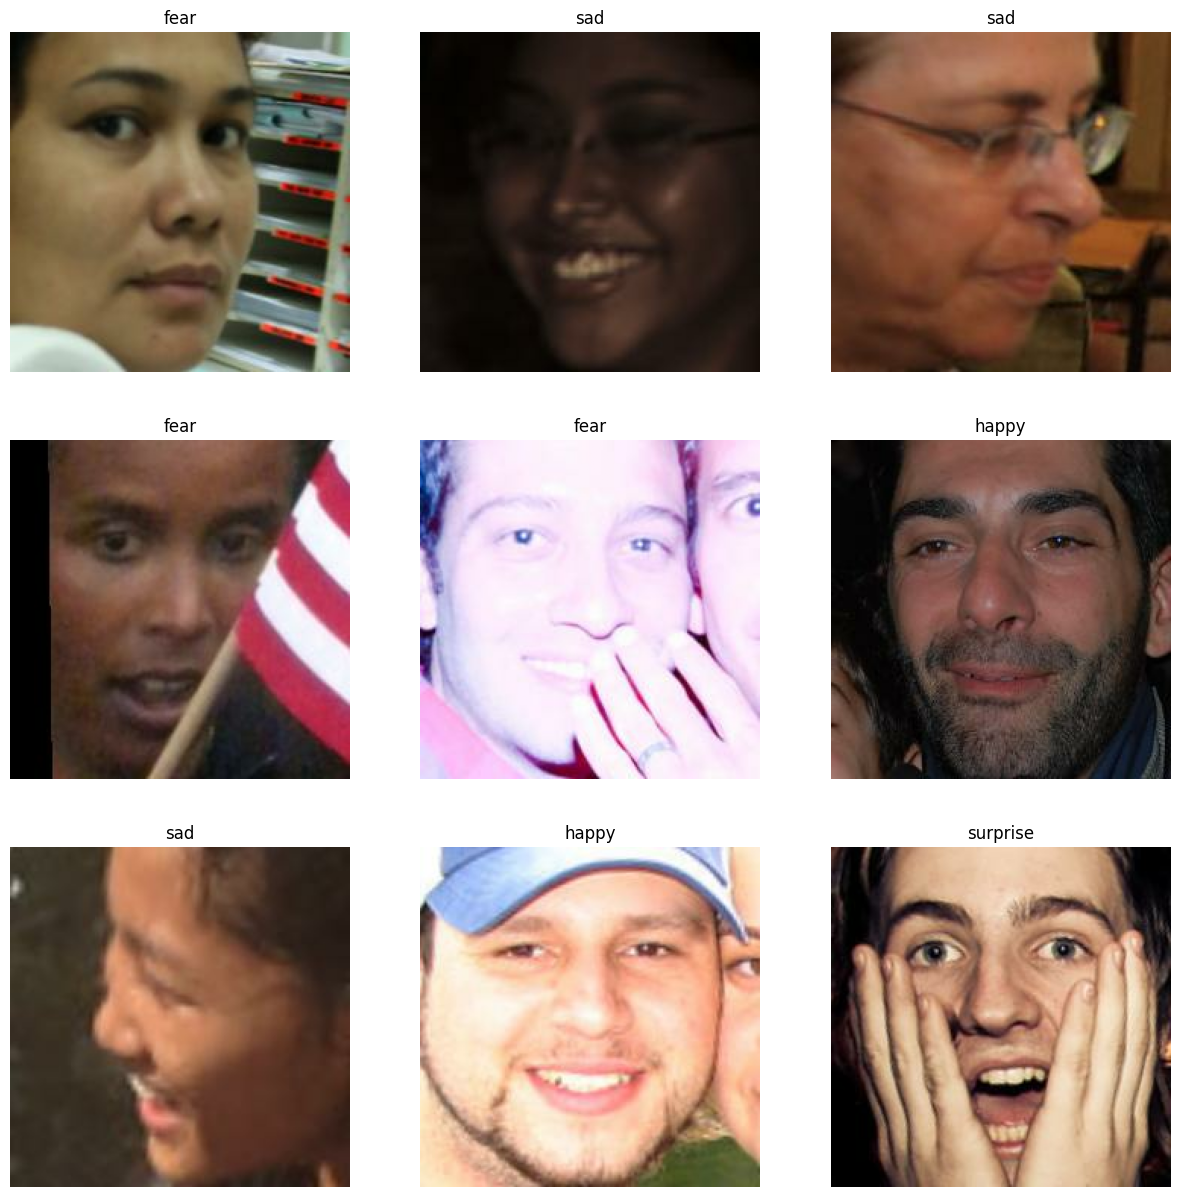

In [ ]:
import matplotlib.pyplot as plt

def display_batch_of_images(images, labels, label_encoder):
    plt.figure(figsize=(15, 15))
    for n in range(min(9, images.shape[0])):  # Display up to 9 images
        ax = plt.subplot(3, 3, n + 1)
        plt.imshow(images[n])
        # Convert one-hot encoded label to class name
        label_index = tf.argmax(labels[n]).numpy()
        class_name = label_encoder.inverse_transform([label_index])[0]
        plt.title(class_name)
        plt.axis('off')
    plt.show()

# Get one batch from the dataset
for images, labels in train_dataset.take(1):
    images = images.numpy()
    labels = labels.numpy()
    display_batch_of_images(images, labels, label_encoder)


In [ ]:
#TODO: Improve the CNN Models

## Build CNN Models

In [ ]:
# # 1. Comparing VGG16, ResNet 50, Custom CNN

# from tensorflow.keras.applications import VGG16
# from tensorflow.keras import layers, models

# def create_vgg16_model(input_shape, num_classes):
#     base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
#     base_model.trainable = False  # Freeze the base model layers

#     model = models.Sequential([
#         base_model,
#         layers.Flatten(),
#         layers.Dense(256, activation='relu'),
#         layers.Dense(num_classes, activation='softmax')
#     ])
#     return model


In [ ]:
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras import layers, models

# def create_resnet50_model(input_shape, num_classes):
#     base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
#     base_model.trainable = False  # Freeze the base model layers

#     model = models.Sequential([
#         base_model,
#         layers.GlobalAveragePooling2D(),
#         layers.Dense(256, activation='relu'),
#         layers.Dense(num_classes, activation='softmax')
#     ])
#     return model


In [ ]:
from tensorflow.keras import layers, models

def create_custom_cnn(input_shape, num_classes):
    model = models.Sequential()

    # First Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Third Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Fourth Convolutional Block
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening Layer
    model.add(layers.Flatten())

    # Fully Connected Layers
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))  # Dropout for regularization

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model


In [ ]:
def compile_and_train(model, train_dataset, val_dataset, model_name):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=10,
        validation_data=val_dataset,  # This should be new_val_dataset
        callbacks=[early_stopping],
        verbose=1
    )

    # Save the trained model
    model.save(f'{model_name}.h5')

    return history


In [ ]:
# Define input shape and number of classes
input_shape = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)
num_classes = len(label_encoder.classes_)

# Create the custom CNN model
custom_cnn_model = create_custom_cnn(input_shape, num_classes)


In [ ]:
# Train the model using the new validation dataset
history_custom_cnn = compile_and_train(custom_cnn_model, train_dataset, new_val_dataset, 'custom_cnn_model')


Epoch 1/10
   8/2711 ━━━━━━━━━━━━━━━━━━━━ 13:30 300ms/step - accuracy: 0.1396 - loss: 3.1346

KeyboardInterrupt: 

In [ ]:
# def evaluate_model(model, val_dataset, model_name):
#     test_loss, test_accuracy = model.evaluate(val_dataset)
#     print(f'{model_name} - Test Accuracy: {test_accuracy:.4f}')
#     return test_accuracy

# # Assuming you have a test_dataset
# accuracy_vgg16 = evaluate_model(vgg16_model, val_dataset, 'VGG16')
# accuracy_resnet50 = evaluate_model(resnet50_model, val_dataset, 'ResNet50')
# accuracy_custom_cnn = evaluate_model(custom_cnn_model, val_dataset, 'Custom CNN')


In [ ]:
# By 11/11/24, complete detection of Algorithmic Bias (Left with Improving CNNs + Output accuracy by races)

In [ ]:
# Load the saved model
saved_model = tf.keras.models.load_model('custom_cnn_model.h5')


In [ ]:
# Create a dataset for predictions (images only)
def create_test_dataset(df, batch_size=32):
    image_paths = df['image_path'].tolist()
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(
        lambda x: load_and_preprocess_image(x, 0)[0],  # We only need the image tensor
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Create the test dataset for prediction
test_dataset_predict = create_test_dataset(test_df, batch_size=batch_size)


In [ ]:
# Make predictions
predictions = saved_model.predict(test_dataset_predict)


172/172 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step


In [ ]:
# Get emotion class names from the label encoder
emotion_classes = label_encoder.classes_

# Create a DataFrame with predicted probabilities
predictions_df = pd.DataFrame(predictions, columns=[f'pred_{emotion}' for emotion in emotion_classes])

# Add predicted dominant emotion
predicted_emotions_encoded = np.argmax(predictions, axis=1)
predicted_emotions = label_encoder.inverse_transform(predicted_emotions_encoded)
predictions_df['pred_dominant_emotion'] = predicted_emotions


In [ ]:
# Reset index to ensure alignment
test_df = test_df.reset_index(drop=True)
predictions_df = predictions_df.reset_index(drop=True)

# Concatenate DataFrames
test_df_with_predictions = pd.concat([test_df, predictions_df], axis=1)


In [ ]:
# Define the output CSV file path
output_csv_path = '/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/test_predictions.csv'

# Save to CSV
test_df_with_predictions.to_csv(output_csv_path, index=False)


### Anlayzing the prediction foralgorithmic bias detection
1. Calculate performance metrics across different demographic groups.
2. Visualize the model's performance to identify potential biases.
3. Conduct statistical tests to determine if observed differences are significant.
4. Provide code examples for plotting and analysis.

In [ ]:
# Load test_predicted csv
import pandas as pd

test_df_with_predictions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Implementation_of_AI_Project/Dataset/FairFace/test_predictions.csv')

In [ ]:
# Convert to categorical data types
test_df_with_predictions['age'] = test_df_with_predictions['age'].astype('category')
test_df_with_predictions['gender'] = test_df_with_predictions['gender'].astype('category')
test_df_with_predictions['race'] = test_df_with_predictions['race'].astype('category')
test_df_with_predictions['dominant_emotion'] = test_df_with_predictions['dominant_emotion'].astype('category')
test_df_with_predictions['pred_dominant_emotion'] = test_df_with_predictions['pred_dominant_emotion'].astype('category')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix


In [ ]:
def calculate_metrics(group_df):
    y_true = group_df['dominant_emotion']
    y_pred = group_df['pred_dominant_emotion']
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
    return accuracy, precision, recall, f1_score


By Gender

In [ ]:
# Initialize a list to store results
results = []

# Loop through each gender
for gender in test_df_with_predictions['gender'].cat.categories:
    group_df = test_df_with_predictions[test_df_with_predictions['gender'] == gender]
    accuracy, precision, recall, f1_score = calculate_metrics(group_df)
    results.append({
        'gender': gender,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    })

# Convert the list of dictionaries to a DataFrame
gender_metrics = pd.DataFrame(results)

print(gender_metrics)


   gender  accuracy  precision    recall  f1_score
0  Female  0.604829   0.577471  0.604829  0.572133
1    Male  0.562762   0.544643  0.562762  0.531584


By Race

In [ ]:
# Initialize a list to store results
results = []

# Loop through each race
for race in test_df_with_predictions['race'].cat.categories:
    group_df = test_df_with_predictions[test_df_with_predictions['race'] == race]
    accuracy, precision, recall, f1_score = calculate_metrics(group_df)
    results.append({
        'race': race,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    })

# Convert the list of dictionaries to a DataFrame
race_metrics = pd.DataFrame(results)

print(race_metrics)


              race  accuracy  precision    recall  f1_score
0            Black  0.593596   0.561507  0.593596  0.557700
1       East Asian  0.552258   0.519269  0.552258  0.515133
2           Indian  0.610677   0.587091  0.610677  0.581802
3  Latino_Hispanic  0.605433   0.592868  0.605433  0.576026
4   Middle Eastern  0.578447   0.563797  0.578447  0.559182
5  Southeast Asian  0.595101   0.561960  0.595101  0.556850
6            White  0.553711   0.518179  0.553711  0.521698


By Age

In [ ]:
# Initialize a list to store results
results = []

# Loop through each age group
for age in test_df_with_predictions['age'].cat.categories:
    group_df = test_df_with_predictions[test_df_with_predictions['age'] == age]
    accuracy, precision, recall, f1_score = calculate_metrics(group_df)
    results.append({
        'age': age,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    })

# Convert the list of dictionaries to a DataFrame
age_metrics = pd.DataFrame(results)

print(age_metrics)


            age  accuracy  precision    recall  f1_score
0           0-2  0.386792   0.404473  0.386792  0.343383
1         10-19  0.629881   0.590999  0.629881  0.598567
2         20-29  0.611346   0.588226  0.611346  0.579273
3           3-9  0.583090   0.561605  0.583090  0.545286
4         30-39  0.606867   0.580023  0.606867  0.575577
5         40-49  0.546565   0.526315  0.546565  0.519752
6         50-59  0.508772   0.465927  0.508772  0.476428
7         60-69  0.428571   0.426232  0.428571  0.405447
8  more than 70  0.508475   0.521469  0.508475  0.492810


### Plot Accuracy

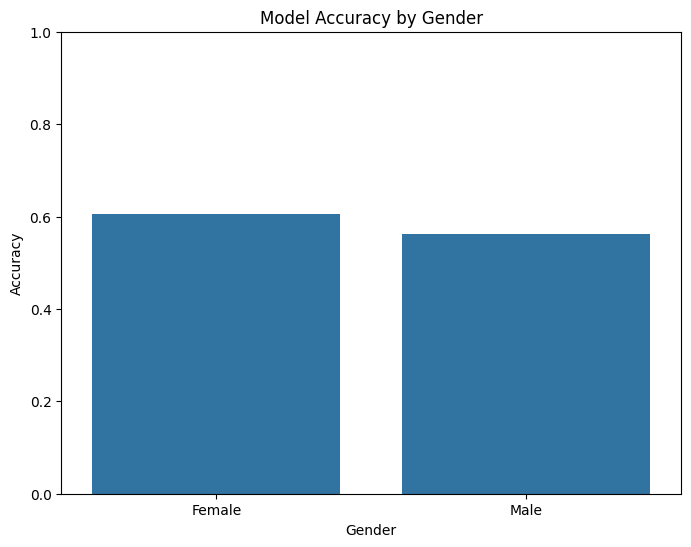

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x='gender', y='accuracy', data=gender_metrics)
plt.title('Model Accuracy by Gender')
plt.ylabel('Accuracy')
plt.xlabel('Gender')
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.show()


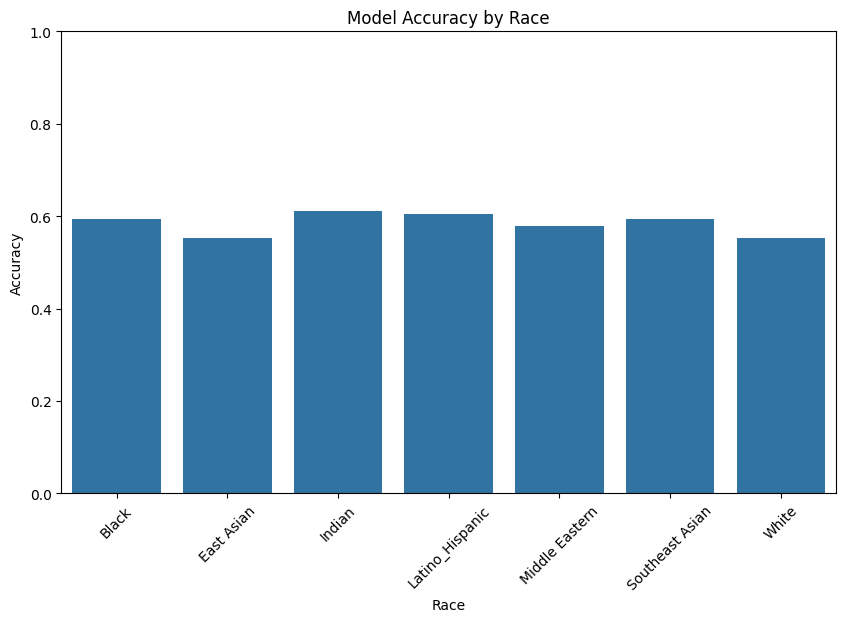

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='race', y='accuracy', data=race_metrics)
plt.title('Model Accuracy by Race')
plt.ylabel('Accuracy')
plt.xlabel('Race')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()


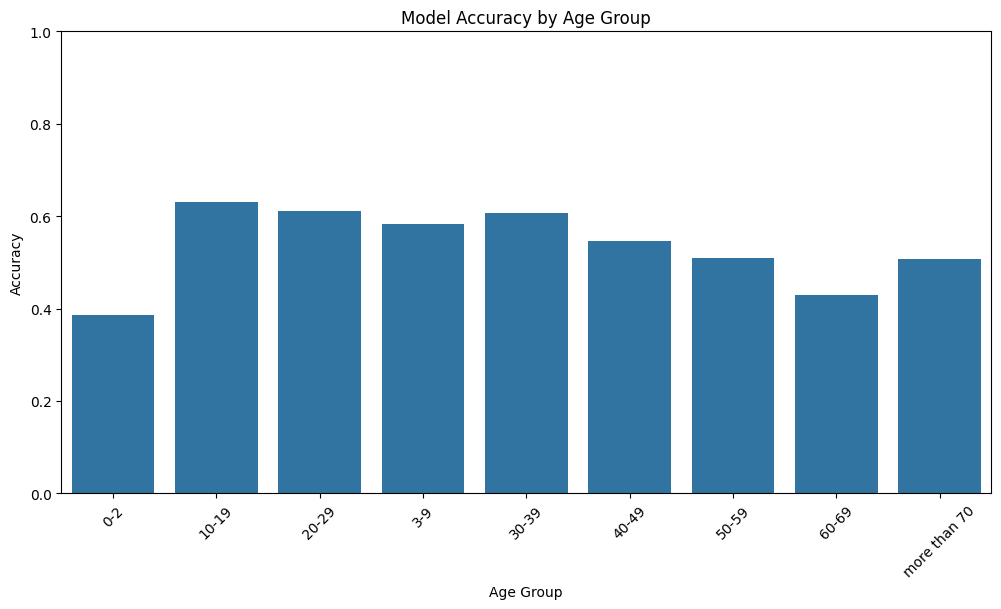

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='age', y='accuracy', data=age_metrics)
plt.title('Model Accuracy by Age Group')
plt.ylabel('Accuracy')
plt.xlabel('Age Group')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()


In [ ]:
from tensorflow.keras import layers, models

def create_custom_cnn(input_shape, num_classes):
    model = models.Sequential()

    # First Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Third Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Fourth Convolutional Block
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flattening Layer
    model.add(layers.Flatten())

    # Fully Connected Layers
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))  # Dropout for regularization

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Example: Print the model architecture
input_shape = (128, 128, 3)  # Example input shape
num_classes = 7  # Example number of classes
model = create_custom_cnn(input_shape, num_classes)
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       2,359,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,785,223 (10.62 MB)

 Trainable params: 2,783,495 (10.62 MB)

 Non-trainable params: 1,728 (6.75 KB)